In [1]:
%%bash
set -e

pip install virtualenv

# Create virtual environment
python3 -m virtualenv myenv
source ./myenv/bin/activate
./myenv/bin/pip install ipykernel
./myenv/bin/pip install numpy pandas scikit-learn matplotlib seaborn imblearn
./myenv/bin/pip freeze > requirements.txt
python3 -m ipykernel install --user --name=myenv --display-name "Python3 (myenv)"

created virtual environment CPython3.10.12.final.0-64 in 208ms
  creator CPython3Posix(dest=/home/joao/inatel/P10/C318/Project/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/joao/snap/code/176/.local/share/virtualenv)
    added seed packages: asttokens==2.4.1, comm==0.2.2, contourpy==1.3.1, cycler==0.12.1, debugpy==1.8.8, decorator==5.1.1, distlib==0.3.9, exceptiongroup==1.2.2, executing==2.1.0, filelock==3.16.1, fonttools==4.55.0, imbalanced_learn==0.12.4, imblearn==0.0, ipykernel==6.29.5, ipython==8.29.0, jedi==0.19.2, joblib==1.4.2, jupyter_client==8.6.3, jupyter_core==5.7.2, kiwisolver==1.4.7, matplotlib==3.9.2, matplotlib_inline==0.1.7, nest_asyncio==1.6.0, numpy==2.1.3, packaging==24.2, pandas==2.2.3, parso==0.8.4, pexpect==4.9.0, pillow==11.0.0, pip==24.3.1, platformdirs==4.3.6, prompt_toolkit==3.0.48, psutil==6.1.0, ptyprocess==0.7.0, pure_eval==0.2.3, pygments

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Criando a função de scorer personalizada (com base no classification_report)
def custom_scorer(y_true, y_pred):
    # Manter o valor de 1 como normal e -1 como anômalo, já que estamos tratando de rótulos do tipo +1 e -1
    y_pred = np.where(y_pred == 1, 1, -1)
    return classification_report(y_true, y_pred, output_dict=True)['recall']

def train(X, Y):
    model = IsolationForest(random_state=42)

    param_grid = {
        'n_estimators': [10, 50, 100, 200, 300, 400],  # Number of trees
        'max_samples': ['auto', 0.5, 0.7],  # Fraction of samples to use for fitting each tree
        'contamination': ['auto', 0.1, 0.25, 0.5],  # Fraction of outliers
        'max_features': [1.0, 0.5]  # Number of features to consider when splitting a node
    }

    scorer = make_scorer(custom_scorer, greater_is_better=True)

    # Set up GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=2, n_jobs=-1, scoring='precision')

    # Fit
    grid_search.fit(X, Y)

    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_

    return best_model, best_params

def evaluate(y_pred, y_test):
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred))

### Reading both Datasets

In [4]:
df_full = pd.read_csv('full_cleaned_dataset.csv')
df_night = pd.read_csv('features_night.csv')
df_day = pd.read_csv('features_day.csv')

### Working with Dataset from Night

In [5]:
df_night.columns

Index(['Unnamed: 0', 'state', 'iRms', 'reactivePotency', 'luminosityLux',
       'fail'],
      dtype='object')

In [6]:
df_features_night = df_night.drop(columns=['Unnamed: 0', 'state', 'fail'])
df_features_night.columns

Index(['iRms', 'reactivePotency', 'luminosityLux'], dtype='object')

In [7]:
df_target_night = df_night['fail']
df_target_night.value_counts()

fail
False    744
True     112
Name: count, dtype: int64

In [8]:
df_target_night = pd.Series(np.where(df_target_night, -1, 1), index=df_target_night.index)

In [9]:
model = IsolationForest(random_state=42, contamination=0.01)
y_pred = model.fit_predict(df_features_night)

In [10]:
evaluate(y_pred, df_target_night)

Classification Report:
              precision    recall  f1-score   support

          -1       0.38      0.03      0.05       112
           1       0.87      0.99      0.93       744

    accuracy                           0.87       856
   macro avg       0.62      0.51      0.49       856
weighted avg       0.81      0.87      0.81       856

Confusion Matrix:
[[  3 109]
 [  5 739]]


In [11]:
y_pred = pd.DataFrame(y_pred,columns=['predict'])
df_export = pd.concat([df_features_night, y_pred, df_target_night], axis=1)
df_export.to_csv('result_night.csv')

[ 1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

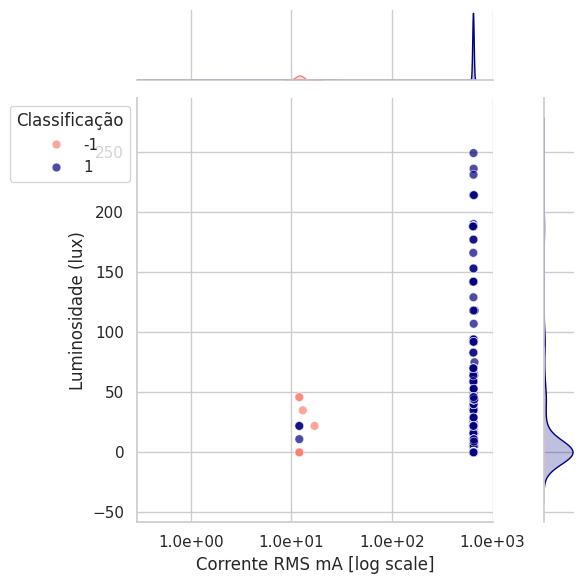

In [12]:
y_pred_np = np.array(y_pred).flatten()
df_features_night['iRms'] = df_features_night['iRms']
print(y_pred_np)
sns.set_theme(style="whitegrid")  # Estilo mais limpo
plot = sns.jointplot(
    data=df_features_night, 
    x="iRms", 
    y="luminosityLux", 
    hue=y_pred_np,
    palette={-1: "salmon", 1: "navy"},  # Paleta de cores personalizada
    alpha=0.7,  # Transparência
    s=40,  # Tamanho dos pontos
)

# Ajustes no eixo X (log)
plot.ax_joint.set_xscale('log')
plot.ax_joint.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1e}'))

# Melhorar os rótulos
plot.ax_joint.set_xlabel("Corrente RMS mA [log scale]", fontsize=12)
plot.ax_joint.set_ylabel("Luminosidade (lux)", fontsize=12)

# Ajustar a legenda
plot.ax_joint.legend_.set_title("Classificação")
plot.ax_joint.legend_.set_bbox_to_anchor((0, 1))  # Coloca fora do gráfico principal

plt.tight_layout()  # Ajusta espaçamentos
plt.show()

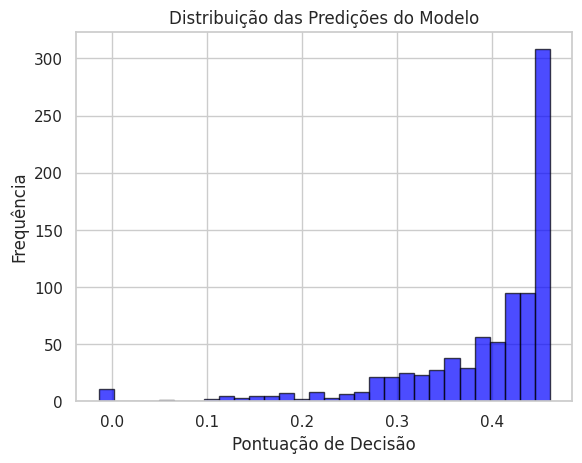

In [13]:
y_pred = model.decision_function(df_features_night)
# Gerar o histograma
plt.hist(y_pred, bins=30, alpha=0.7, color='blue', edgecolor='black')  # Ajuste bins conforme necessário

# Configurar o gráfico
plt.title("Distribuição das Predições do Modelo")
plt.xlabel("Pontuação de Decisão")
plt.ylabel("Frequência")

# Mostrar o gráfico
plt.show()

### Working with Dataset from Day

In [14]:
df_day.columns

Index(['Unnamed: 0', 'state', 'iRms', 'reactivePotency', 'luminosityLux',
       'fail'],
      dtype='object')

In [15]:
df_features_day = df_day.drop(columns=['Unnamed: 0', 'state', 'fail'])
df_features_day.columns

Index(['iRms', 'reactivePotency', 'luminosityLux'], dtype='object')

In [16]:
df_target_day = df_day['fail']
df_target_day.value_counts()

fail
False    712
True      96
Name: count, dtype: int64

In [17]:
df_target_day = pd.Series(np.where(df_target_day, -1, 1), index=df_target_day.index)

In [18]:
model = IsolationForest(random_state=42, contamination=0.025)
y_pred = model.fit_predict(df_features_day)

In [19]:
evaluate(y_pred, df_target_day)

Classification Report:
              precision    recall  f1-score   support

          -1       0.14      0.03      0.05        96
           1       0.88      0.97      0.93       712

    accuracy                           0.86       808
   macro avg       0.51      0.50      0.49       808
weighted avg       0.79      0.86      0.82       808

Confusion Matrix:
[[  3  93]
 [ 18 694]]


In [20]:
y_pred = pd.DataFrame(y_pred,columns=['predict'])
df_export = pd.concat([df_features_day, y_pred], axis=1)
df_export.to_csv('result_day.csv')

[ 1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1 -1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1 -1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

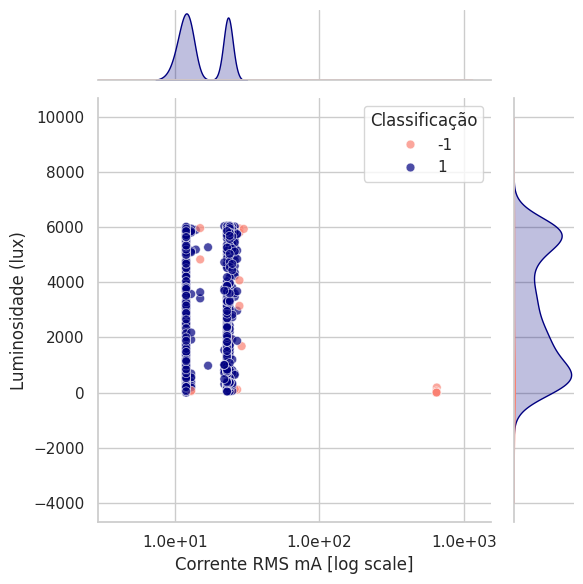

In [21]:
y_pred_np = np.array(y_pred).flatten()
df_features_day['iRms'] = df_features_day['iRms']
print(y_pred_np)
sns.set_theme(style="whitegrid")  # Estilo mais limpo
plot = sns.jointplot(
    data=df_features_day, 
    x="iRms", 
    y="luminosityLux", 
    hue=y_pred_np,
    palette={-1: "salmon", 1: "navy"},  # Paleta de cores personalizada
    alpha=0.7,  # Transparência
    s=40,  # Tamanho dos pontos
)

# Ajustes no eixo X (log)
plot.ax_joint.set_xscale('log')
plot.ax_joint.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.1e}'))

# Melhorar os rótulos
plot.ax_joint.set_xlabel("Corrente RMS mA [log scale]", fontsize=12)
plot.ax_joint.set_ylabel("Luminosidade (lux)", fontsize=12)

# Ajustar a legenda
plot.ax_joint.legend_.set_title("Classificação")
plot.ax_joint.legend_.set_bbox_to_anchor((1, 1))  # Coloca fora do gráfico principal

plt.tight_layout()  # Ajusta espaçamentos
plt.show()

In [22]:
df_features_day['iRms'].value_counts(normalize=True)

iRms
12.0     0.444307
23.0     0.293317
24.0     0.115099
25.0     0.045792
26.0     0.027228
13.0     0.021040
22.0     0.016089
27.0     0.009901
15.0     0.004950
28.0     0.004950
642.0    0.002475
17.0     0.002475
645.0    0.002475
14.0     0.002475
29.0     0.001238
30.0     0.001238
646.0    0.001238
641.0    0.001238
644.0    0.001238
643.0    0.001238
Name: proportion, dtype: float64

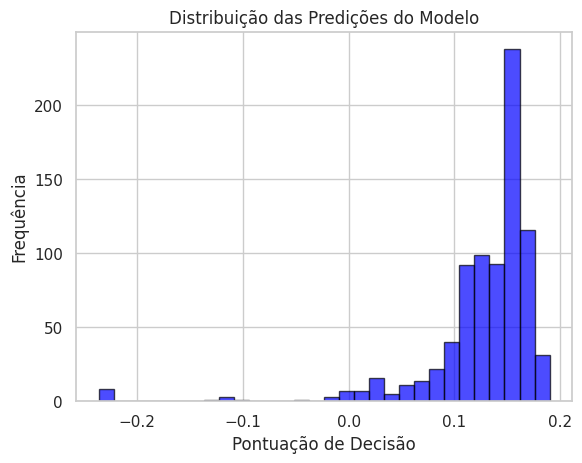

In [23]:
y_pred = model.decision_function(df_features_day)
# Gerar o histograma
plt.hist(y_pred, bins=30, alpha=0.7, color='blue', edgecolor='black')  # Ajuste bins conforme necessário

# Configurar o gráfico
plt.title("Distribuição das Predições do Modelo")
plt.xlabel("Pontuação de Decisão")
plt.ylabel("Frequência")

# Mostrar o gráfico
plt.show()

### Working with full dataset

In [24]:
df_full.columns

Index(['Unnamed: 0', 'timestamp', 'state', 'iRms', 'reactivePotency',
       'luminosityLux', 'fail'],
      dtype='object')

In [25]:
df_features_full = df_full.drop(columns=['timestamp', 'Unnamed: 0', 'state', 'fail'])
df_features_full.columns

Index(['iRms', 'reactivePotency', 'luminosityLux'], dtype='object')

In [26]:
df_target_full = df_full['fail']
df_target_full.value_counts()

fail
False    1456
True      208
Name: count, dtype: int64

In [27]:
df_target_full = pd.Series(np.where(df_target_full, -1, 1), index=df_target_full.index)

In [28]:
model = IsolationForest(random_state=42, contamination=0.05)
y_pred = model.fit_predict(df_features_full)

In [29]:
evaluate(y_pred, df_target_full)

Classification Report:
              precision    recall  f1-score   support

          -1       0.21      0.09      0.12       208
           1       0.88      0.95      0.92      1456

    accuracy                           0.85      1664
   macro avg       0.55      0.52      0.52      1664
weighted avg       0.80      0.85      0.82      1664

Confusion Matrix:
[[  18  190]
 [  66 1390]]


In [30]:
y_pred = pd.DataFrame(y_pred,columns=['predict'])
df_export = pd.concat([df_features_full, y_pred], axis=1)
df_export.to_csv('result_full.csv')

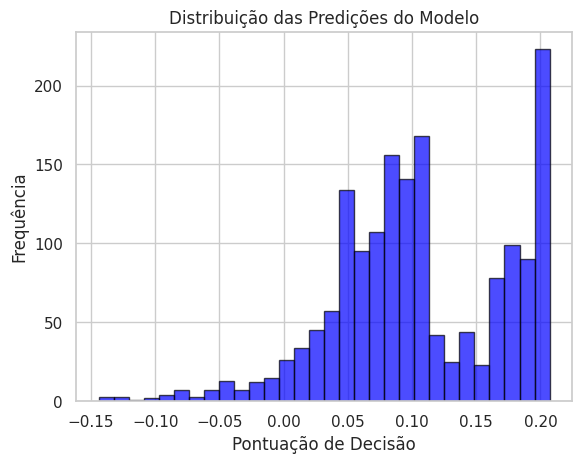

In [31]:
y_pred = model.decision_function(df_features_full)
# Gerar o histograma
plt.hist(y_pred, bins=30, alpha=0.7, color='blue', edgecolor='black')  # Ajuste bins conforme necessário

# Configurar o gráfico
plt.title("Distribuição das Predições do Modelo")
plt.xlabel("Pontuação de Decisão")
plt.ylabel("Frequência")

# Mostrar o gráfico
plt.show()

### Tuning the model

In [32]:
best_model, best_params = train(df_features_full, df_target_full)
y_pred = best_model.predict(df_features_full)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=50; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=auto, n_estimators=100; total time=   0.2s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=10; total time=   0.0s
[CV] END contamination=auto, max_features=1.0, max_samples=0.5, n_estimators=50; total time=   0.1s
[CV] END contamination=auto, ma

In [33]:
evaluate(y_pred, df_target_full)

Classification Report:
              precision    recall  f1-score   support

          -1       0.14      0.29      0.19       208
           1       0.88      0.76      0.81      1456

    accuracy                           0.70      1664
   macro avg       0.51      0.52      0.50      1664
weighted avg       0.79      0.70      0.74      1664

Confusion Matrix:
[[  60  148]
 [ 356 1100]]


In [34]:
best_params

{'contamination': 0.25,
 'max_features': 1.0,
 'max_samples': 0.7,
 'n_estimators': 10}

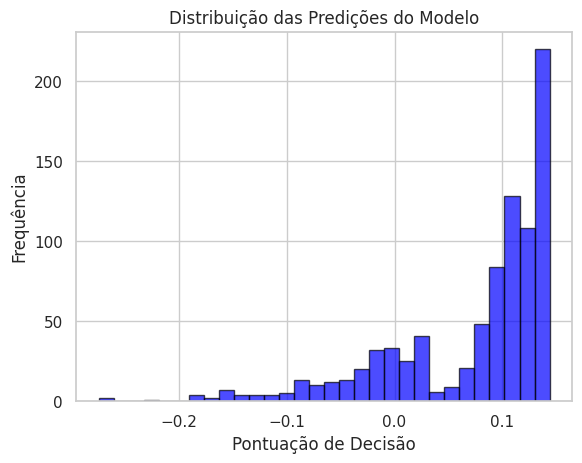

In [35]:
y_pred = best_model.decision_function(df_features_night)

# Gerar o histograma
plt.hist(y_pred, bins=30, alpha=0.7, color='blue', edgecolor='black')  # Ajuste bins conforme necessário

# Configurar o gráfico
plt.title("Distribuição das Predições do Modelo")
plt.xlabel("Pontuação de Decisão")
plt.ylabel("Frequência")

# Mostrar o gráfico
plt.show()

In [36]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Definir o melhor limiar inicial e suas métricas associadas
best_value = -0.3
best_metric = 0

# Métrica escolhida: maximizar o F1-Score (ou outra métrica relevante)
for value in np.arange(-0.5, 0.5, 0.01):
    # Ajustar previsões com base no limiar atual
    y_pred_adjusted = np.where(y_pred >= value, 1, -1)
    
    # Calcular recall, precisão e F1-Score
    precision = precision_score(df_target_night, y_pred_adjusted, pos_label=1)
    recall = recall_score(df_target_night, y_pred_adjusted, pos_label=1)
    f1 = f1_score(df_target_night, y_pred_adjusted, pos_label=1)
    accuracy = accuracy_score(df_target_night, y_pred_adjusted)

    # Escolher a métrica que você quer otimizar (aqui F1-Score)
    metric_to_optimize = f1
    
    # Atualizar o melhor limiar se a métrica melhorar
    if metric_to_optimize > best_metric:
        best_metric = metric_to_optimize
        best_value = value

print(f"Melhor limiar: {best_value}, Melhor métrica: {best_metric}")

Melhor limiar: -0.17999999999999972, Melhor métrica: 0.9323308270676691


/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/joao/inatel/P10/C318/Project/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [37]:
y_pred_best = np.where(y_pred >= best_value, 1, -1)

pd.Series(y_pred_best).value_counts()

 1    852
-1      4
Name: count, dtype: int64